In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ipywidgets as widgets
from ipywidgets import interact, fixed, interactive
from IPython.display import display

In [2]:
original_dataset = pd.read_csv('data\\terry-stops.csv')
print(original_dataset.columns) 

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')


## Data Cleaning

Drop:
+ Subject ID: Group-level statistics are of interest and not individual ones.
+ GO/SC Num (General Order and Street Check Number):  this identifier relates report to parent. sometimes has a one-to-many relationship. 

NaN Swaps:
+ 'Officer Squad', 'Initial Call Type', 'Final Call Type','Call Type', 'Precinct', 'Sector', 'Beat': 'NaN' -> 'Not Reported'

String Swaps:
+ Subject Perceived Gender: '-' -> 'Not Reported'
+ Subject Reported Race: '-' -> 'Not Reported'
+ Officer Gender: '-' -> 'Not Reported'
+ Weapon Type: '-' -> 'Not Reported'
+ unify some of the Race terms: multi-racial (remove "two or more races"), hispanic(remove "hispanic or latino"), Black (remove "black or african american")

String Edits:
+ Final Call Type: remove '--' prefix

Datestamp:
+ combine 'Reported Date' and 'Reported Time' to 'Reported Datestamp' in datetime format
+ Drop 'Reported date' and 'Reported Time'

Data
+ arrest_flag, frisk_flag Y/N to 1/0

In [3]:
from cmath import isnan


police_stops = original_dataset.drop(['Subject ID', 'GO / SC Num'], axis=1)
police_stops.replace(to_replace='-', value='Not Reported', inplace=True)

nan_swap_keys=['Officer Squad', 'Initial Call Type', 'Final Call Type','Call Type', 'Precinct', 'Sector','Beat']
police_stops[nan_swap_keys] = police_stops[nan_swap_keys].fillna(value='Not Reported')

police_stops['Officer Gender'] = police_stops['Officer Gender'].replace(to_replace='N', value='Not Reported')
police_stops = police_stops.drop(police_stops[police_stops["Officer Gender"]=="Not Reported"].index, axis=0) #drop them actually.

# race description cleaning
police_stops['Officer Race'] = police_stops['Officer Race'].apply(lambda x:x.replace("Two or More Races",'Multi-Racial'))
police_stops['Officer Race'] = police_stops['Officer Race'].apply(lambda x:x.replace("Hispanic or Latino",'Hispanic'))
police_stops['Officer Race'] = police_stops['Officer Race'].apply(lambda x:x.replace("Black or African American",'Black'))
police_stops['Officer Race'] = police_stops['Officer Race'].apply(lambda x:x.replace("Not Specified","Not Reported"))

police_stops['Subject Perceived Race'] = police_stops['Subject Perceived Race'].apply(lambda x:x.replace("American Indian / Alaskan Native",'American Indian/Alaskan Native'))

police_stops['Final Call Type'] = police_stops['Final Call Type'].apply(lambda x:x.replace('--',''))

police_stops['Reported Datestamp'] = police_stops['Reported Date'] + ' '+ police_stops['Reported Time']
police_stops['Reported Datestamp'] = police_stops['Reported Datestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f0'))
police_stops["Officer YOB"].fillna(1900, inplace=True)
police_stops["Officer YOB"] = police_stops["Officer YOB"].astype(int)
police_stops = police_stops.drop(['Reported Date', 'Reported Time'], axis=1)

# Add "Officer Age (at Stop Date)" column
ONE_YEAR = datetime.timedelta(days=365)
yobs = police_stops['Officer YOB'].astype(int).apply(lambda x:datetime.datetime(year=x, month=1, day=1))
police_stops["Officer Age"]= np.round((police_stops["Reported Datestamp"] - yobs)/ONE_YEAR, 1)
police_stops = police_stops.drop(police_stops[police_stops["Officer Age"]>=80].index, axis=0) #drop super old
SUBJECT_AGE_ORDER = ["Not Reported","1 - 17","18 - 25","26 - 35","36 - 45","46 - 55","56 and Above"]

def bucketize_age(x) -> str: 
    x = round(x)
    if 1>x<=17:
        age = "1 - 17"
    elif 18>x<=25:
        age = "18 - 25"
    elif 26>x<=35:
        age = '26 - 35'
    elif 36>x<=45:
        age = '36 - 45'
    elif 46>x<=55:
        age = '46 - 55'
    elif 56<x:
        age = '56 and Above'
    else:
        age = 'Not Reported'
    return age

police_stops["Officer Age Group"] = police_stops["Officer Age"].apply(lambda x:bucketize_age(x))

police_stops["Arrest Flag"] = police_stops["Arrest Flag"].map({"Y":True, "N":False})
police_stops["Frisk Flag"] = police_stops["Frisk Flag"].map({"Y":True, "N":False})

police_stops["Frisk Flag"] = police_stops["Frisk Flag"].fillna(value=False)
police_stops["Arrest Flag"] = police_stops["Arrest Flag"].fillna(value=False)


In [4]:
police_stops.head(5)
police_stops["Officer Race"].unique()

array(['White', 'Multi-Racial', 'Black', 'Not Reported',
       'American Indian/Alaska Native', 'Asian', 'Hispanic',
       'Nat Hawaiian/Oth Pac Islander'], dtype=object)

Re-organize by Racial features: [Officer Race, Subject Perceived Race]

In [5]:
by_race = police_stops.groupby(by=["Officer Race", "Subject Perceived Race"]).count()
frisks_race = by_race['Frisk Flag'].divide(police_stops.shape[0]).multiply(100).reset_index()
arrests_race = by_race['Arrest Flag'].divide(police_stops.shape[0]).multiply(100).reset_index()

## Demographics

What are the baseline demographics for officers, and subjects of Terry-Stops?
- Stacked histogram visualizations that show officer/subject race, gender, and age groups.

Distributions are scaled by count, within each racial description. therefore does not inidcate total headcount per group.


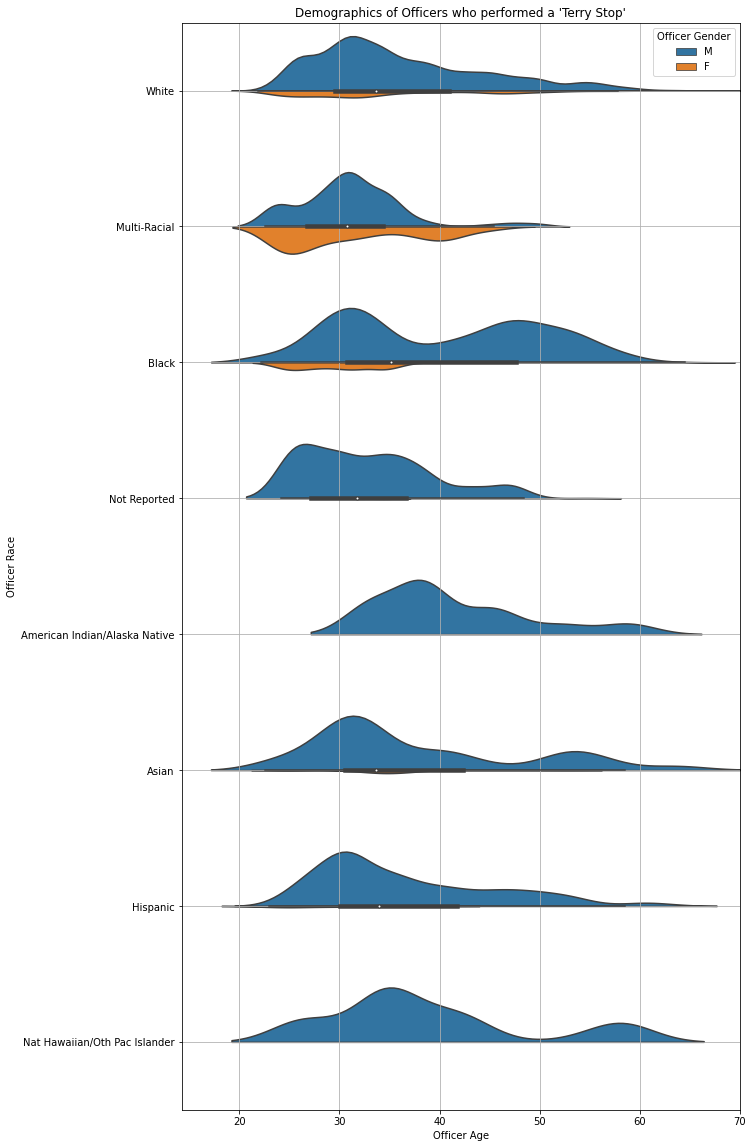

In [6]:
fig = plt.figure(figsize=(10,20))
sns.violinplot(data=police_stops, x="Officer Age", y="Officer Race", hue="Officer Gender", inner="box", split=True, scale="count", scale_hue=True)
plt.xlim(right=70)
plt.grid(visible=True)
plt.title("Demographics of Officers who performed a 'Terry Stop'")
print("Distributions are scaled by count, within each racial description. therefore does not inidcate total headcount per group.")

We can see from the violin plot that there are very few women. In fact:

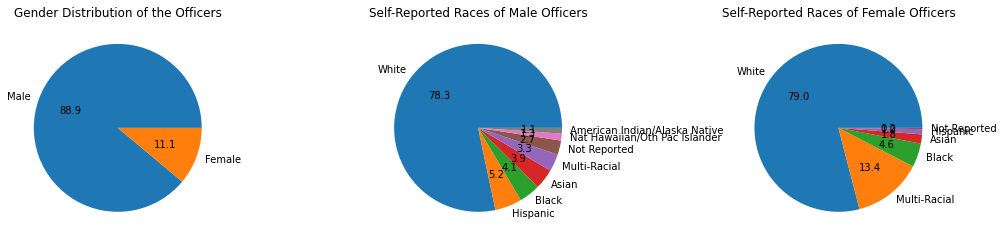

In [7]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(14,12)
plt.subplot(1,3,1)
plt.pie(police_stops["Officer Gender"].value_counts(normalize=True), labels=["Male", "Female"], autopct='%2.1f')
ax[0].set_title('Gender Distribution of the Officers')

plt.subplot(1,3,2)
plt.pie(police_stops[police_stops["Officer Gender"]=='M']["Officer Race"].value_counts(normalize=True),
    labels=list(police_stops[police_stops["Officer Gender"]=='M']["Officer Race"].value_counts(normalize=True).keys()),
    autopct='%2.1f')
ax[1].set_title('Self-Reported Races of Male Officers')

plt.subplot(1,3,3)
plt.pie(police_stops[police_stops["Officer Gender"]=='F']["Officer Race"].value_counts(normalize=True),
    labels=police_stops[police_stops["Officer Gender"]=='F']["Officer Race"].value_counts(normalize=True).keys(),
    autopct='%2.1f')
ax[2].set_title('Self-Reported Races of Female Officers')

fig.tight_layout()
plt.show()


Subjects involved in Terry Stops

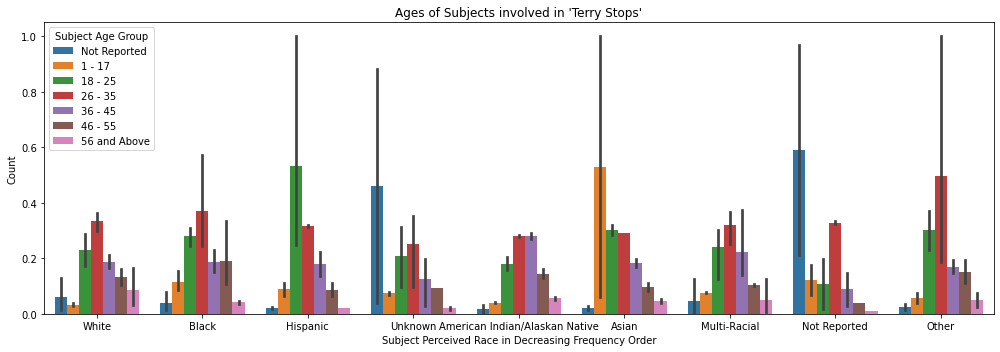

In [8]:
a=police_stops[["Subject Age Group","Subject Perceived Race","Subject Perceived Gender"]].groupby(by=["Subject Perceived Race","Subject Perceived Gender"]).value_counts(normalize=True)
a=a.reset_index().rename(columns={0:'Count'})
fig = plt.figure(figsize=(14,5))
sns.barplot(data=a, x='Subject Perceived Race', y="Count", hue="Subject Age Group", dodge=True,
    order=police_stops["Subject Perceived Race"].value_counts(normalize=True, sort=True, ascending=False).keys(),
    hue_order=SUBJECT_AGE_ORDER)
plt.xlabel("Subject Perceived Race in Decreasing Frequency Order")
plt.title("Ages of Subjects involved in 'Terry Stops'")
fig.tight_layout()


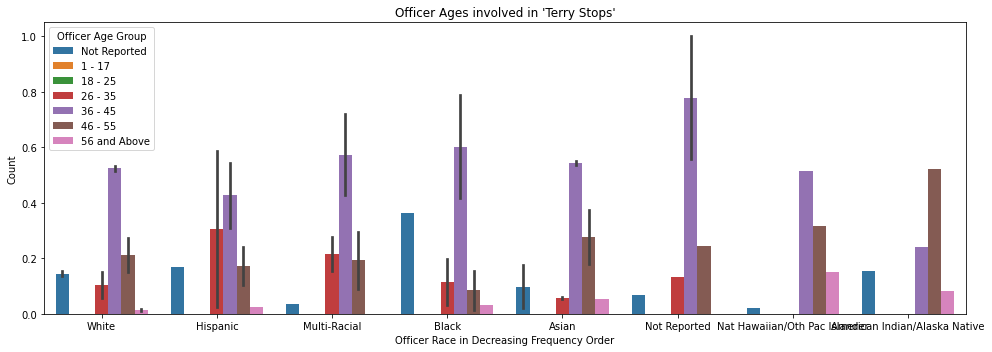

In [9]:
a=police_stops[["Officer Age Group","Officer Race","Officer Gender"]].groupby(by=["Officer Race","Officer Gender"]).value_counts(normalize=True)
a=a.reset_index().rename(columns={0:'Count'})
fig = plt.figure(figsize=(14,5))
sns.barplot(data=a, x='Officer Race', y="Count", hue="Officer Age Group", dodge=True,
    order=police_stops["Officer Race"].value_counts(normalize=True, sort=True, ascending=False).keys(),
    hue_order=SUBJECT_AGE_ORDER)
plt.xlabel("Officer Race in Decreasing Frequency Order")
plt.title("Officer Ages involved in 'Terry Stops'")
fig.tight_layout()

Interactive Pie-charts for arrests and race

In [10]:
def pie_plot(df, officer_or_subject, dropdown) -> None:
    if officer_or_subject=='Officer Race':
        label = 'Subject Perceived Race'
    else:
        label = 'Officer Race'

    pie_plot = plt.figure()
    plt.title(f'Arrests: {label}')
    pie_plot = plt.pie(x=df[df[officer_or_subject] == dropdown]['Arrest Flag'], labels=df[df[officer_or_subject] == dropdown][label], autopct='%2.1f')
    plt.tight_layout()
    plt.show()
    
    
officer_race_dropdown = widgets.Dropdown(
    options=arrests_race["Officer Race"].unique(),
    description="Officer Race",
    disabled=False,
    value=arrests_race["Officer Race"].unique()[0]
)


# figure = plt.figure()
w = interact(pie_plot,df=fixed(arrests_race), officer_or_subject=fixed("Officer Race"), dropdown=officer_race_dropdown)
# display(widgets.VBox([officer_race_dropdown, w]))

interactive(children=(Dropdown(description='Officer Race', options=('American Indian/Alaska Native', 'Asian', …

In [11]:
subject_race_dropdown = widgets.Dropdown(
    options=arrests_race["Subject Perceived Race"].unique(),
    description="Subject Perceived Race",
    disabled=False,
    value=arrests_race["Subject Perceived Race"].unique()[0]
)
w=interact(pie_plot,df=fixed(arrests_race), officer_or_subject=fixed("Subject Perceived Race"), dropdown=subject_race_dropdown)


interactive(children=(Dropdown(description='Subject Perceived Race', options=('American Indian/Alaskan Native'…

## Weapons

What (if any) weapons are found?

In [12]:
def pie_weapons(df, who, race, remove_none) -> None:

    pie_plot = plt.figure()
    plt.title(f'Weapons found: {who}: {race}')

    if remove_none:
        df = df.drop(df[df['Weapon Type']=='None'].index)
        df = df.drop(df[df['Weapon Type']=='Not Reported'].index)

    pie_plot = sns.barplot(y=100*df[df[who] == race]['Weapon Type'].value_counts(normalize=True, sort=True, ascending=False),
        x=df[df[who] == race]['Weapon Type'].value_counts(normalize=True, sort=True, ascending=False).keys(),
        )
    plt.xticks(rotation=45)
    plt.tight_layout()

toggle_who = widgets.ToggleButtons(
    options=["Officer Race", "Subject Perceived Race"],
    disabled=False,
    button_style='',
    value="Officer Race"
)
dropdown_race = widgets.Dropdown(
    options=police_stops[toggle_who.value].unique(),
    description="Race",
    disabled=False,
)
checkbox_remove_none = widgets.ToggleButtons(
    options=[True, False],
    value=True,
    description='Show only those who had weapons?',
    disabled=False,
    indent=False
)
#out = interact(pie_weapons, df=fixed(police_stops), who=toggle_who, race=dropdown_race, remove_none=checkbox_remove_none)

out = widgets.interactive_output(pie_weapons, {"df":fixed(police_stops), "who":toggle_who, "race":dropdown_race, "remove_none":checkbox_remove_none})
display(widgets.VBox([toggle_who,dropdown_race,checkbox_remove_none]),out)


Output()

# How Likely were you to get arrested, if?

In [43]:
remove_list = ["Terry Stop ID", "Stop Resolution", "Officer ID", "Arrest Flag", "Reported Datestamp","Initial Call Type", "Final Call Type", "Officer Age", "Officer YOB", "Officer Squad", "Beat", "Sector", "Precinct"]
feature_list = list(police_stops.drop(columns=remove_list).columns)
outcome = police_stops["Arrest Flag"]

In [44]:
# what are the per-feature likelihoods, assuming complete independence

arrest_proportion=[]
f=[]
fv=[]
fcl_proportion = []
for feature in feature_list:
    for cl in police_stops[feature].unique():
        # probabilities = police_stops[police_stops[feature]==cl]["Arrest Flag"].value_counts(normalize=True) #not robust to cases where True=0
        arrest_proportion.append(police_stops[police_stops[feature]==cl]["Arrest Flag"].sum()/police_stops[police_stops[feature]==cl]["Arrest Flag"].shape[0])
        fcl_proportion.append(police_stops[police_stops[feature]==cl].shape[0]/police_stops.shape[0])
        f.append(feature)
        fv.append(cl)

#create df in one go, somehow in this case slower than the alternates
outcomes = pd.DataFrame.from_dict(data={"Feature":f, "Feature Value":fv, "Arrest Proportion":arrest_proportion, "Feature Propotion":fcl_proportion})
outcomes

,Feature,Feature Value,Arrest Proportion,Feature Propotion
0,Subject Age Group,36 - 45,0.228337,0.196925
1,Subject Age Group,26 - 35,0.236572,0.325557
2,Subject Age Group,18 - 25,0.230093,0.222982
3,Subject Age Group,Not Reported,0.161483,0.032129
4,Subject Age Group,46 - 55,0.195002,0.124558
5,Subject Age Group,56 and Above,0.192573,0.044504
6,Subject Age Group,1 - 17,0.221182,0.053344
7,Weapon Type,None,0.211387,0.944312
8,Weapon Type,Lethal Cutting Instrument,0.421389,0.042045
9,Weapon Type,Handgun,0.510753,0.007148


In [45]:
X = police_stops[feature_list].to_numpy() 
y = outcome.to_numpy()

from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


encoder = OrdinalEncoder()
encoder.feature_names = feature_list
encoder.fit(X)
X_enc = encoder.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, shuffle=True, random_state=19, train_size=0.75)

## Categorical NB
classifier_CNB = CategoricalNB()

print(type(classifier_CNB).__name__)
classifier_CNB.fit(X_train,y_train)
print(f'Accuracy: {classifier_CNB.score(X_test, y_test):2.3f}')


CategoricalNB
Accuracy: 0.771


RandomForestClassifier
Accuracy: 0.765


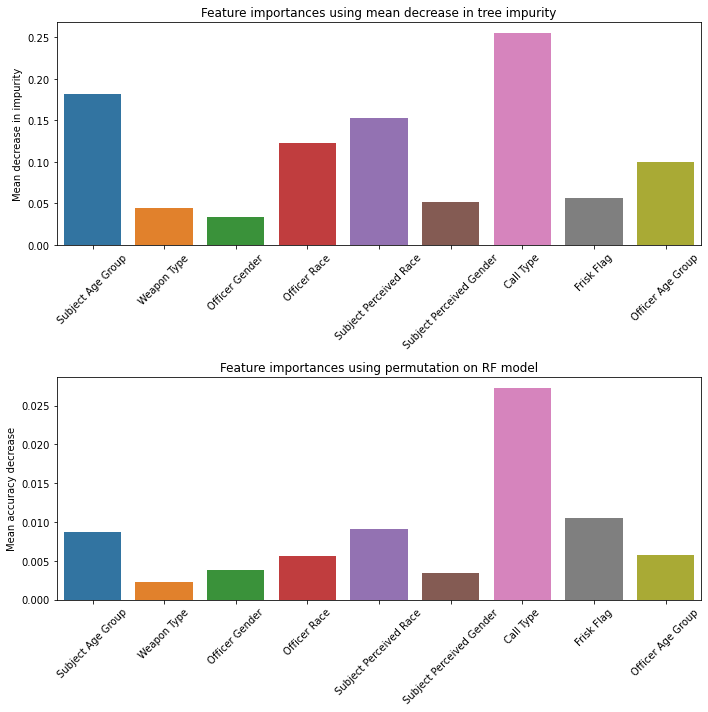

In [46]:
## RF
classifier_RNF = RandomForestClassifier(n_estimators=100, random_state=19)
print(type(classifier_RNF).__name__)
classifier_RNF.fit(X_train,y_train)
print(f'Accuracy: {classifier_RNF.score(X_test, y_test):2.3f}')

permutation_importances_result = permutation_importance(classifier_RNF, X_test, y_test, n_repeats=19, random_state=19, n_jobs=2)
permutation_feature_importances = pd.Series(permutation_importances_result.importances_mean, index=feature_list)

impurity_importances = classifier_RNF.feature_importances_
forest_importances = pd.Series(impurity_importances, index=feature_list)

#plot impurity importance
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax = plt.subplot(2,1,1)
sns.barplot(x=forest_importances.keys(), y=forest_importances.values)
ax.set_title("Feature importances using mean decrease in tree impurity")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45)

#plot permutation importance
ax = plt.subplot(2,1,2)
sns.barplot(x=permutation_feature_importances.keys(), y=permutation_feature_importances.values)
ax.set_title("Feature importances using permutation on RF model")
ax.set_ylabel("Mean accuracy decrease")
plt.xticks(rotation=45)

fig.tight_layout()
plt.show()

In [74]:
def randomly_generate_scenario(encoder, verbose=False, n=1):
    features = encoder.categories_

    feature_vector = np.zeros(shape=(n,encoder.n_features_in_), dtype=np.int32)
    scenario=[]

    for i, feature in enumerate(encoder.feature_names):
        choice=np.random.randint(low=0, high=len(features[i]), size=n, dtype=np.int32)
        feature_vector[...,i] = choice
        scenario.append(features[i][choice])

    if verbose:
        print(feature_vector)
        print(scenario)

    return feature_vector, scenario

def randomly_generate_scenario2(encoder, verbose=False, n=1):
    n_features = encoder.n_features_in_

    feature_vector = np.random.randint(low=np.zeros(shape=(n,n_features)),
                high=[len(encoder.categories_[i]) for i in range(len(encoder.categories_))],
                size=(n,n_features),
                dtype=np.int32)
                
    scenario = encoder.inverse_transform(feature_vector)

    return feature_vector, scenario

def generate_scenario(example, encoder):
    features = encoder.categories_
    scenario=[]
    for i in range(len(encoder.feature_names)):
        s=[]
        for n in range(example.shape[0]):
            condition = int(example[n,i])
            s.append(features[i][condition])
        scenario.append(s)
    return scenario

def display_scenario(scenario, encoder):
    features = encoder.feature_names

    for i,condition in enumerate(scenario):
        s = f'Feature: {features[i]} has condition: {condition}'
        print(s)

def infer(X, model):
    y = model.predict(X)
    return y

def reverse_query(example, encoder, dataframe, verbose=False):
    result=pd.DataFrame()
    features = encoder.feature_names
    for n in range(example.shape[0]):
        stacked = ""
        
        for i in range(len(encoder.feature_names)):
            condition = encoder.categories_[i][int(example[n,i])]

            if isinstance(condition, str):
                s = f'(dataframe["{features[i]}"]=="{condition}")'
            else:
                s = f'(dataframe["{features[i]}"]=={condition})'
                
            if i != encoder.n_features_in_-1:
                s += ' & '
            
            stacked += s
        stacked = 'dataframe[' + stacked + ']'

        if verbose:
            print("Query: ", stacked)
        temp = pd.eval(stacked, parser='pandas')

        result = pd.concat([result,temp])

    return result

def reverse_dfquery(example:np.ndarray, encoder:OrdinalEncoder, dataframe:pd.DataFrame, verbose=False):

    result=pd.DataFrame(columns=dataframe.columns)
    features = encoder.feature_names
    
    for n in range(example.shape[0]):
        
        stacked = ""
        s =""
        scenario = encoder.inverse_transform(example[n,:].reshape(1,-1))[0]

        for i, condition in enumerate(scenario):

            if (' ' in features[i]):
                col = f'(`{features[i]}`=='
            else:
                col = f'({features[i]}=='

            if isinstance(condition, str):
                cond = f'"{condition}")'
            else:
                cond = f'{condition})'
            
            if i != encoder.n_features_in_-1:
                s += col + cond +' and '
            else:
                s += col + cond
            
        stacked += s
        
        if verbose:
            print("Query: ", stacked)
            
        temp = dataframe.query(expr=stacked, inplace=False)
        result = pd.concat([result, temp])
    
    return result

def check_results(predictions:np.ndarray, dataframe:pd.DataFrame):
    historical_true_proportion = dataframe["Arrest Flag"].sum()/dataframe.size
    prediction_true_proportion = predictions.sum()/len(predictions)
    return prediction_true_proportion, historical_true_proportion

In [59]:
test_query = np.array([[3., 8., 1., 7., 2., 1., 3., 0., 2.]])
scenario_test_query = generate_scenario(test_query,encoder)
display_scenario(scenario_test_query, encoder)
predictions = infer(test_query, classifier_RNF)
print(f'Classifer Suggest Arrest Flag: {[*predictions]}')
rev_query = reverse_dfquery(test_query, encoder, police_stops, verbose=True)
rev_query

Feature: Subject Age Group has condition: ['36 - 45']
Feature: Weapon Type has condition: ['None']
Feature: Officer Gender has condition: ['M']
Feature: Officer Race has condition: ['White']
Feature: Subject Perceived Race has condition: ['Black']
Feature: Subject Perceived Gender has condition: ['Male']
Feature: Call Type has condition: ['ONVIEW']
Feature: Frisk Flag has condition: [False]
Feature: Officer Age Group has condition: ['46 - 55']
Classifer Suggest Arrest Flag: [False]
Query:  (`Subject Age Group`=="36 - 45") and (`Weapon Type`=="None") and (`Officer Gender`=="M") and (`Officer Race`=="White") and (`Subject Perceived Race`=="Black") and (`Subject Perceived Gender`=="Male") and (`Call Type`=="ONVIEW") and (`Frisk Flag`==False) and (`Officer Age Group`=="46 - 55")


,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,...,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Reported Datestamp,Officer Age,Officer Age Group
0,36 - 45,10012,Not Reported,None,1735,1977,M,White,Black,Male,...,ONVIEW,Not Reported,False,False,East,E,E2,2015-03-18 09:58:00,38.2,46 - 55
983,36 - 45,41772,GO Report,None,2154,1983,M,White,Black,Male,...,ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,False,False,East,G,G3,2018-07-06 14:58:00,35.5,46 - 55
1722,36 - 45,41533,GO Report,None,1602,1981,M,White,Black,Male,...,ONVIEW,SOUTH PCT 3RD W - SAM,False,False,South,O,O1,2018-06-30 04:56:00,37.5,46 - 55
2122,36 - 45,25879,Arrest with GO or Supplemental,None,1828,1979,M,White,Black,Male,...,ONVIEW,WEST PCT 3RD W - DAVID BEATS,True,False,West,M,M2,2017-02-10 23:10:00,38.1,46 - 55
2620,36 - 45,24793,Street Check,None,1180,1978,M,White,Black,Male,...,ONVIEW,WEST PCT OPS - ACT NIGHT,False,False,West,D,D1,2016-04-25 23:52:00,38.3,46 - 55
7407,36 - 45,37669,Street Check,None,1714,1980,M,White,Black,Male,...,ONVIEW,EAST PCT 1ST W - E/G RELIEF (CHARLIE),False,False,West,K,K3,2018-01-25 10:09:00,38.1,46 - 55
8275,36 - 45,17468,GO Report,None,1140,1976,M,White,Black,Male,...,ONVIEW,Not Reported,False,False,West,K,K3,2015-12-31 16:30:00,40.0,46 - 55
9436,36 - 45,28758,GO Report,None,1602,1981,M,White,Black,Male,...,ONVIEW,SOUTH PCT 3RD W - SAM,False,False,Unknown,99,99,2017-07-07 21:31:00,36.5,46 - 55
9853,36 - 45,11501,GO Report,None,920,1971,M,White,Black,Male,...,ONVIEW,WEST PCT OPS - CPT,False,False,West,M,M2,2015-06-08 12:59:00,44.5,46 - 55
11655,36 - 45,24864,Arrest with GO or Supplemental,None,1585,1979,M,White,Black,Male,...,ONVIEW,NORTH PCT 2ND WATCH - NORTH BEATS,True,False,North,L,L2,2016-12-14 19:22:00,38.0,46 - 55


In [52]:
test_query_multi=X_enc[0:2,:]
scenario_multi = generate_scenario(test_query_multi,encoder)
display_scenario(scenario_multi, encoder)
predictions = infer(test_query_multi, classifier_RNF)
print(f'Classifer Suggests Arrest Flag: {[*predictions]}')
rev_query = reverse_dfquery(test_query_multi, encoder, police_stops, verbose=True)
rev_query

Feature: Subject Age Group has condition: ['36 - 45', '26 - 35']
Feature: Weapon Type has condition: ['None', 'None']
Feature: Officer Gender has condition: ['M', 'M']
Feature: Officer Race has condition: ['White', 'White']
Feature: Subject Perceived Race has condition: ['Black', 'Black']
Feature: Subject Perceived Gender has condition: ['Male', 'Male']
Feature: Call Type has condition: ['ONVIEW', '911']
Feature: Frisk Flag has condition: [False, False]
Feature: Officer Age Group has condition: ['46 - 55', '36 - 45']
Classifer Suggests Arrest Flag: [False, False]
Query:  (`Subject Age Group`=="36 - 45") and (`Weapon Type`=="None") and (`Officer Gender`=="M") and (`Officer Race`=="White") and (`Subject Perceived Race`=="Black") and (`Subject Perceived Gender`=="Male") and (`Call Type`=="ONVIEW") and (`Frisk Flag`==False) and (`Officer Age Group`=="46 - 55")
Query:  (`Subject Age Group`=="26 - 35") and (`Weapon Type`=="None") and (`Officer Gender`=="M") and (`Officer Race`=="White") and 

,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,...,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Reported Datestamp,Officer Age,Officer Age Group
0,36 - 45,10012,Not Reported,None,1735,1977,M,White,Black,Male,...,ONVIEW,Not Reported,False,False,East,E,E2,2015-03-18 09:58:00,38.2,46 - 55
983,36 - 45,41772,GO Report,None,2154,1983,M,White,Black,Male,...,ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,False,False,East,G,G3,2018-07-06 14:58:00,35.5,46 - 55
1722,36 - 45,41533,GO Report,None,1602,1981,M,White,Black,Male,...,ONVIEW,SOUTH PCT 3RD W - SAM,False,False,South,O,O1,2018-06-30 04:56:00,37.5,46 - 55
2122,36 - 45,25879,Arrest with GO or Supplemental,None,1828,1979,M,White,Black,Male,...,ONVIEW,WEST PCT 3RD W - DAVID BEATS,True,False,West,M,M2,2017-02-10 23:10:00,38.1,46 - 55
2620,36 - 45,24793,Street Check,None,1180,1978,M,White,Black,Male,...,ONVIEW,WEST PCT OPS - ACT NIGHT,False,False,West,D,D1,2016-04-25 23:52:00,38.3,46 - 55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25045,26 - 35,40426,GO Report,None,1823,1988,M,White,Black,Male,...,911,NORTH PCT 2ND W - L/U RELIEF,False,False,North,L,L2,2018-05-22 23:19:00,30.4,36 - 45
25147,26 - 35,28399,GO Report,None,2142,1988,M,White,Black,Male,...,911,WEST PCT 2ND W - DAVID,False,False,West,M,M3,2017-06-23 22:48:00,29.5,36 - 45
25212,26 - 35,23552,Arrest with GO or Supplemental,None,2191,1991,M,White,Black,Male,...,911,TRAINING - FIELD TRAINING SQUAD,True,False,South,S,S1,2016-10-09 17:57:00,25.8,36 - 45
25257,26 - 35,33861,GO for Prosecutorial Referral,None,1894,1983,M,White,Black,Male,...,911,EAST PCT 1ST W - E/G RELIEF (CHARLIE),False,False,East,E,E3,2017-11-26 05:18:00,34.9,36 - 45


In [75]:
hits=0
runs=0
while hits <= 0:
    example_query, scenario = randomly_generate_scenario2(encoder=encoder, verbose=False, n=1)
    predictions = infer(example_query, classifier_RNF)
    rev_query = reverse_dfquery(example_query, encoder, police_stops, verbose=False)
    hits=rev_query.size
    runs +=1

display_scenario(scenario,encoder)
prediction_true_proportion, historical_true_proportion = check_results(predictions, rev_query)
print(f'Match(es) found after {runs:1} runs')
print(f'Classifer Suggests Arrest Flag: {[*predictions]}')
print(f'The results had a historical true percentage of {historical_true_proportion}')

rev_query

Feature: Subject Age Group has condition: ['Not Reported' 'None' 'M' 'White' 'American Indian/Alaskan Native' 'Male'
 'Not Reported' False 'Not Reported']
Match(es) found after 347 runs
Classifer Suggests Arrest Flag: [False]
The results had a historical true percentage of 0.0


,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,...,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Reported Datestamp,Officer Age,Officer Age Group
20930,Not Reported,11456,Street Check,None,707,1969,M,White,American Indian/Alaskan Native,Male,...,Not Reported,WEST PCT 3RD W - K/Q RELIEF,False,False,Not Reported,Not Reported,Not Reported,2015-06-11 01:21:00,46.5,Not Reported
23800,Not Reported,11457,Street Check,None,707,1969,M,White,American Indian/Alaskan Native,Male,...,Not Reported,WEST PCT 3RD W - K/Q RELIEF,False,False,Not Reported,Not Reported,Not Reported,2015-06-11 01:25:00,46.5,Not Reported


In [88]:
import pickle
import joblib

#joblib for SKL per documentation
fname_me = 'models\\model_and_encoder.joblib'
joblib.dump((classifier_CNB, encoder),fname_me)

#pickle for the dataframe
fname_db = 'data\\police_stops.pickle'
police_stops.to_pickle(path=fname_db)